# Create TFLite model

In [ ]:
!nvidia-smi

Wed May 18 11:10:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q tflite-model-maker
!pip install -q pycocotools
!pip install -q tflite-support

     |████████████████████████████████| 642 kB 7.8 MB/s 
     |████████████████████████████████| 596 kB 73.0 MB/s 
     |████████████████████████████████| 3.4 MB 50.6 MB/s 
     |████████████████████████████████| 77 kB 6.3 MB/s 
     |████████████████████████████████| 1.1 MB 79.0 MB/s 
     |████████████████████████████████| 237 kB 100.4 MB/s 
     |████████████████████████████████| 120 kB 64.0 MB/s 
     |████████████████████████████████| 42.5 MB 1.3 MB/s 
     |████████████████████████████████| 1.2 MB 68.6 MB/s 
     |████████████████████████████████| 10.9 MB 74.2 MB/s 
     |████████████████████████████████| 6.4 MB 53.2 MB/s 
     |████████████████████████████████| 840 kB 64.1 MB/s 
     |████████████████████████████████| 87 kB 7.7 MB/s 
     |████████████████████████████████| 25.3 MB 1.2 MB/s 
     |████████████████████████████████| 47.8 MB 1.3 MB/s 
     |████████████████████████████████| 352 kB 99.4 MB/s 
     |████████████████████████████████| 99 kB 10.0 MB/s 
     |████████████

In [ ]:
#mount the storage which contains your image data
#storage can be replaced with Google Storage instead of Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Create and train new custom model

import numpy as np
import os

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.object_detector import DataLoader
from tensorflow_examples.lite.model_maker.third_party.efficientdet.keras import train
from tensorflow_examples.lite.model_maker.third_party.efficientdet.keras import train_lib

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

In [ ]:
batch_size = 8
epochs = 1000
checkpoint_dir = "/content/drive/MyDrive/test/checkpoints"

In [ ]:
#Create object detector's spec to be distributed on edge device
spec = object_detector.EfficientDetLite0Spec(
    model_name='efficientdet-lite0',
    uri='https://tfhub.dev/tensorflow/efficientdet/lite0/feature-vector/1', 
    hparams='',
    model_dir=checkpoint_dir,
    epochs=epochs,
    batch_size=batch_size,
    steps_per_execution=1,
    moving_average_decay=0,
    var_freeze_expr='(efficientnet|fpn_cells|resample_p6)',
    tflite_max_detections=10, 
    strategy=None,
    tpu=None,
    gcp_project=None,
    tpu_zone=None, 
    use_xla=False, 
    profile=False, 
    debug=False, 
    tf_random_seed=111111,
    verbose=1
)

In [ ]:
#Load datasets
train_data, validation_data, test_data = object_detector.DataLoader.from_csv('/content/drive/MyDrive/test/data_set/data_set.csv')

In [ ]:
#Create the object detector
detector = object_detector.create(train_data, 
                                model_spec=spec, 
                                batch_size=batch_size, 
                                train_whole_model=True, 
                                validation_data=validation_data,
                                epochs=epochs,
                                do_train=False
                                )

In [ ]:
#Convert the datasets for training
train_ds, steps_per_epoch, _ = detector._get_dataset_and_steps(train_data, batch_size, is_training=True)                          
validation_ds, validation_steps, val_json_file = detector._get_dataset_and_steps(validation_data, batch_size, is_training=False)

In [ ]:
#Get the interal keras model
model = detector.create_model()

In [ ]:
#Copy what the API interally does as setup
config = spec.config
config.update(
    dict(
        steps_per_epoch=steps_per_epoch,
        eval_samples=batch_size * validation_steps,
        val_json_file=val_json_file,
        batch_size=batch_size
    )
)
#Build model within compile call basically
train.setup_model(model, config)
model.summary()

Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  multiple                  3234464   
                                                                 
 class_net/class-predict (Se  multiple                 3501      
 parableConv2D)                                                  
                                                                 
 box_net/box-predict (Separa  multiple                 2916      
 bleConv2D)                                                      
                                                                 
Total params: 3,240,881
Trainable params: 3,193,745
Non-trainable params: 47,136
_________________________________________________________________


In [ ]:
#Load the weights from the latest checkpoint
try:
  latest = tf.train.latest_checkpoint(checkpoint_dir)
  completed_epochs = int(latest.split("/")[-1].split("-")[1])
  model.load_weights(latest)
  print("Checkpoint found {}".format(latest))
except Exception as e:
  completed_epochs = 0
  print("Checkpoint not found: ", e)

Checkpoint not found:  'NoneType' object has no attribute 'split'


In [ ]:
#Train the model and save checkpoints at the end of every epoch
hist = model.fit(
          train_ds,
          epochs=completed_epochs+100,
          initial_epoch=completed_epochs, 
          steps_per_epoch=steps_per_epoch,
          validation_data=validation_ds,
          validation_steps=validation_steps,
          callbacks=train_lib.get_callbacks(config.as_dict(), validation_ds)
      )

Epoch 1/100
356/356 [==============================] - ETA: 0s - det_loss: 2.1113 - cls_loss: 0.9387 - box_loss: 0.0235 - reg_l2_loss: 0.0643 - loss: 2.1756 - learning_rate: 0.0090 - gradient_norm: 5.4816
Epoch 1: saving model to /content/drive/MyDrive/test/checkpoints/ckpt-1
356/356 [==============================] - 203s 437ms/step - det_loss: 2.1098 - cls_loss: 0.9386 - box_loss: 0.0234 - reg_l2_loss: 0.0643 - loss: 2.1742 - learning_rate: 0.0090 - gradient_norm: 5.4734 - val_det_loss: 2.0702 - val_cls_loss: 0.7464 - val_box_loss: 0.0265 - val_reg_l2_loss: 0.0651 - val_loss: 2.1352
Epoch 2/100
356/356 [==============================] - ETA: 0s - det_loss: 1.7406 - cls_loss: 0.7909 - box_loss: 0.0190 - reg_l2_loss: 0.0656 - loss: 1.8063 - learning_rate: 0.0100 - gradient_norm: 4.4009
Epoch 2: saving model to /content/drive/MyDrive/test/checkpoints/ckpt-2
356/356 [==============================] - 166s 464ms/step - det_loss: 1.7401 - cls_loss: 0.7907 - box_loss: 0.0190 - reg_l2_loss: 

In [ ]:
#inject the trained model into the object detector
detector.model = model
detector.evaluate(test_data)

167/167 [==============================] - 62s 337ms/step



{'AP': 0.15272248,
 'AP50': 0.30781847,
 'AP75': 0.13577911,
 'AP_/bollard': 0.13066581,
 'AP_/car': 0.50498676,
 'AP_/person': 0.18321928,
 'AP_/pole': 0.015041715,
 'AP_/potted_plant': 0.098565616,
 'AP_/traffic_light': 0.046753258,
 'AP_/tree_trunk': 0.089824855,
 'APl': 0.34199142,
 'APm': 0.08004273,
 'APs': 0.014275352,
 'ARl': 0.53462756,
 'ARm': 0.22960626,
 'ARmax1': 0.13364966,
 'ARmax10': 0.26875943,
 'ARmax100': 0.30038133,
 'ARs': 0.034222305}

In [ ]:
#@title Train the trained model with additional data to increase performance

#Load additional datasets to train more
train_data, validation_data, test_data = object_detector.DataLoader.from_csv('/content/drive/MyDrive/test/data_set/new_data_set.csv')

In [ ]:
#Create the object detector with freezing option after the first work
#Since only the last localization and classification layout have to be trained
detector = object_detector.create(train_data, 
                                model_spec=spec, 
                                batch_size=batch_size, 
                                train_whole_model=False, 
                                validation_data=validation_data,
                                epochs=epochs,
                                do_train=False
                                )

In [ ]:
#Convert the datasets for training
train_ds, steps_per_epoch, _ = detector._get_dataset_and_steps(train_data, batch_size, is_training=True)                          
validation_ds, validation_steps, val_json_file = detector._get_dataset_and_steps(validation_data, batch_size, is_training=False)

In [ ]:
#Get the interal keras model
model = detector.create_model()

In [ ]:
#Copy what the API interally does as setup
config = spec.config
config.update(
    dict(
        steps_per_epoch=steps_per_epoch,
        eval_samples=batch_size * validation_steps,
        val_json_file=val_json_file,
        batch_size=batch_size
    )
)
#Build model within compile call basically
train.setup_model(model, config)
model.summary()

In [ ]:
#Load the weights from the latest checkpoint
try:
  latest = tf.train.latest_checkpoint(checkpoint_dir)
  completed_epochs = int(latest.split("/")[-1].split("-")[1])
  model.load_weights(latest)
  print("Checkpoint found {}".format(latest))
except Exception as e:
  completed_epochs = 0
  print("Checkpoint not found: ", e)

In [ ]:
#Train the model and save checkpoints at the end of every epoch
hist = model.fit(
          train_ds,
          epochs=completed_epochs+100,
          initial_epoch=completed_epochs, 
          steps_per_epoch=steps_per_epoch,
          validation_data=validation_ds,
          validation_steps=validation_steps,
          callbacks=train_lib.get_callbacks(config.as_dict(), validation_ds)
      )

In [ ]:
#inject the trained model into the object detector
detector.model = model
detector.evaluate(test_data)

In [ ]:
#Save and export the trained model
export_dir = "/content/drive/MyDrive/test/"
detector.export(export_dir = export_dir, tflite_filename='detect_model.tflite')
quant_config = QuantizationConfig.for_float16()
detector.export(export_dir = export_dir, tflite_filename='detect_model_float16.tflite', quantization_config = quant_config)

In [ ]:
#@title Load the trained TFLite model and define some visualization functions

#@markdown This code comes from the TFLite Object Detection [Raspberry Pi sample](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi).

from pathlib import Path

import PIL
import PIL.Image as PILI

print(PIL.__version__)

img_path = Path('/content/drive/MyDrive/test/Bbox_1_new/Bbox_0040/MP_SEL_004314.jpg')
print(img_path.exists())
img = PILI.open(img_path).convert('RGB')

!pip uninstall opencv-python-headless
!pip install opencv-python-headless==4.5.2.52

import platform
import json

from typing import List, NamedTuple
from tflite_support import metadata


Interpreter = tf.lite.Interpreter
load_delegate = tf.lite.experimental.load_delegate

# pylint: enable=g-import-not-at-top


class ObjectDetectorOptions(NamedTuple):
  """A config to initialize an object detector."""

  enable_edgetpu: bool = False
  """Enable the model to run on EdgeTPU."""

  label_allow_list: List[str] = None
  """The optional allow list of labels."""

  label_deny_list: List[str] = None
  """The optional deny list of labels."""

  max_results: int = -1
  """The maximum number of top-scored detection results to return."""

  num_threads: int = 1
  """The number of CPU threads to be used."""

  score_threshold: float = 0.0
  """The score threshold of detection results to return."""


class Rect(NamedTuple):
  """A rectangle in 2D space."""
  left: float
  top: float
  right: float
  bottom: float


class Category(NamedTuple):
  """A result of a classification task."""
  label: str
  score: float
  index: int


class Detection(NamedTuple):
  """A detected object as the result of an ObjectDetector."""
  bounding_box: Rect
  categories: List[Category]


def edgetpu_lib_name():
  """Returns the library name of EdgeTPU in the current platform."""
  return {
      'Darwin': 'libedgetpu.1.dylib',
      'Linux': 'libedgetpu.so.1',
      'Windows': 'edgetpu.dll',
  }.get(platform.system(), None)


class ObjectDetector:
  """A wrapper class for a TFLite object detection model."""

  _OUTPUT_LOCATION_NAME = 'location'
  _OUTPUT_CATEGORY_NAME = 'category'
  _OUTPUT_SCORE_NAME = 'score'
  _OUTPUT_NUMBER_NAME = 'number of detections'

  def __init__(
      self,
      model_path: str,
      options: ObjectDetectorOptions = ObjectDetectorOptions()
  ) -> None:
    """Initialize a TFLite object detection model.
    Args:
        model_path: Path to the TFLite model.
        options: The config to initialize an object detector. (Optional)
    Raises:
        ValueError: If the TFLite model is invalid.
        OSError: If the current OS isn't supported by EdgeTPU.
    """

    # Load metadata from model.
    displayer = metadata.MetadataDisplayer.with_model_file(model_path)

    # Save model metadata for preprocessing later.
    model_metadata = json.loads(displayer.get_metadata_json())
    process_units = model_metadata['subgraph_metadata'][0]['input_tensor_metadata'][0]['process_units']
    mean = 0.0
    std = 1.0
    for option in process_units:
      if option['options_type'] == 'NormalizationOptions':
        mean = option['options']['mean'][0]
        std = option['options']['std'][0]
    self._mean = mean
    self._std = std

    # Load label list from metadata.
    file_name = displayer.get_packed_associated_file_list()[0]
    label_map_file = displayer.get_associated_file_buffer(file_name).decode()
    label_list = list(filter(lambda x: len(x) > 0, label_map_file.splitlines()))
    self._label_list = label_list

    # Initialize TFLite model.
    if options.enable_edgetpu:
      if edgetpu_lib_name() is None:
        raise OSError("The current OS isn't supported by Coral EdgeTPU.")
      interpreter = Interpreter(
          model_path=model_path,
          experimental_delegates=[load_delegate(edgetpu_lib_name())],
          num_threads=options.num_threads)
    else:
      interpreter = Interpreter(
          model_path=model_path, num_threads=options.num_threads)

    interpreter.allocate_tensors()
    input_detail = interpreter.get_input_details()[0]

    # From TensorFlow 2.6, the order of the outputs become undefined.
    # Therefore we need to sort the tensor indices of TFLite outputs and to know
    # exactly the meaning of each output tensor. For example, if
    # output indices are [601, 599, 598, 600], tensor names and indices aligned
    # are:
    #   - location: 598
    #   - category: 599
    #   - score: 600
    #   - detection_count: 601
    # because of the op's ports of TFLITE_DETECTION_POST_PROCESS
    # (https://github.com/tensorflow/tensorflow/blob/a4fe268ea084e7d323133ed7b986e0ae259a2bc7/tensorflow/lite/kernels/detection_postprocess.cc#L47-L50).
    sorted_output_indices = sorted(
        [output['index'] for output in interpreter.get_output_details()])
    self._output_indices = {
        self._OUTPUT_LOCATION_NAME: sorted_output_indices[0],
        self._OUTPUT_CATEGORY_NAME: sorted_output_indices[1],
        self._OUTPUT_SCORE_NAME: sorted_output_indices[2],
        self._OUTPUT_NUMBER_NAME: sorted_output_indices[3],
    }

    self._input_size = input_detail['shape'][2], input_detail['shape'][1]
    self._is_quantized_input = input_detail['dtype'] == np.uint8
    self._interpreter = interpreter
    self._options = options

  def detect(self, input_image: np.ndarray) -> List[Detection]:
    """Run detection on an input image.
    Args:
        input_image: A [height, width, 3] RGB image. Note that height and width
          can be anything since the image will be immediately resized according
          to the needs of the model within this function.
    Returns:
        A Person instance.
    """
    image_height, image_width, _ = input_image.shape

    input_tensor = self._preprocess(input_image)

    self._set_input_tensor(input_tensor)
    self._interpreter.invoke()

    # Get all output details
    boxes = self._get_output_tensor(self._OUTPUT_LOCATION_NAME)
    classes = self._get_output_tensor(self._OUTPUT_CATEGORY_NAME)
    scores = self._get_output_tensor(self._OUTPUT_SCORE_NAME)
    count = int(self._get_output_tensor(self._OUTPUT_NUMBER_NAME))

    return self._postprocess(boxes, classes, scores, count, image_width,
                             image_height)

  def _preprocess(self, input_image: np.ndarray) -> np.ndarray:
    """Preprocess the input image as required by the TFLite model."""

    # Resize the input
    input_tensor = cv2.resize(input_image, self._input_size)

    # Normalize the input if it's a float model (aka. not quantized)
    if not self._is_quantized_input:
      input_tensor = (np.float32(input_tensor) - self._mean) / self._std

    # Add batch dimension
    input_tensor = np.expand_dims(input_tensor, axis=0)

    return input_tensor

  def _set_input_tensor(self, image):
    """Sets the input tensor."""
    tensor_index = self._interpreter.get_input_details()[0]['index']
    input_tensor = self._interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image

  def _get_output_tensor(self, name):
    """Returns the output tensor at the given index."""
    output_index = self._output_indices[name]
    tensor = np.squeeze(self._interpreter.get_tensor(output_index))
    return tensor

  def _postprocess(self, boxes: np.ndarray, classes: np.ndarray,
                   scores: np.ndarray, count: int, image_width: int,
                   image_height: int) -> List[Detection]:
    """Post-process the output of TFLite model into a list of Detection objects.
    Args:
        boxes: Bounding boxes of detected objects from the TFLite model.
        classes: Class index of the detected objects from the TFLite model.
        scores: Confidence scores of the detected objects from the TFLite model.
        count: Number of detected objects from the TFLite model.
        image_width: Width of the input image.
        image_height: Height of the input image.
    Returns:
        A list of Detection objects detected by the TFLite model.
    """
    results = []

    # Parse the model output into a list of Detection entities.
    for i in range(count):
      if scores[i] >= self._options.score_threshold:
        y_min, x_min, y_max, x_max = boxes[i]
        bounding_box = Rect(
            top=int(y_min * image_height),
            left=int(x_min * image_width),
            bottom=int(y_max * image_height),
            right=int(x_max * image_width))
        class_id = int(classes[i])
        category = Category(
            score=scores[i],
            label=self._label_list[class_id],  # 0 is reserved for background
            index=class_id)
        result = Detection(bounding_box=bounding_box, categories=[category])
        results.append(result)

    # Sort detection results by score ascending
    sorted_results = sorted(
        results,
        key=lambda detection: detection.categories[0].score,
        reverse=True)

    # Filter out detections in deny list
    filtered_results = sorted_results
    if self._options.label_deny_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label not in self.
              _options.label_deny_list, filtered_results))

    # Keep only detections in allow list
    if self._options.label_allow_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label in self._options.
              label_allow_list, filtered_results))

    # Only return maximum of max_results detection.
    if self._options.max_results > 0:
      result_count = min(len(filtered_results), self._options.max_results)
      filtered_results = filtered_results[:result_count]

    return filtered_results


_MARGIN = 10  # pixels
_ROW_SIZE = 10  # pixels
_FONT_SIZE = 1
_FONT_THICKNESS = 1
_TEXT_COLOR = (0, 0, 255)  # red


def visualize(
    image: np.ndarray,
    detections: List[Detection],
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detections: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detections:
    # Draw bounding_box
    start_point = detection.bounding_box.left, detection.bounding_box.top
    end_point = detection.bounding_box.right, detection.bounding_box.bottom
    cv2.rectangle(image, start_point, end_point, _TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    class_name = category.label
    probability = round(category.score, 2)
    result_text = class_name + ' (' + str(probability) + ')'
    text_location = (_MARGIN + detection.bounding_box.left,
                     _MARGIN + _ROW_SIZE + detection.bounding_box.top)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                _FONT_SIZE, _TEXT_COLOR, _FONT_THICKNESS)

  return image

Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.64.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-65fa80df.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-09fe7800.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dis

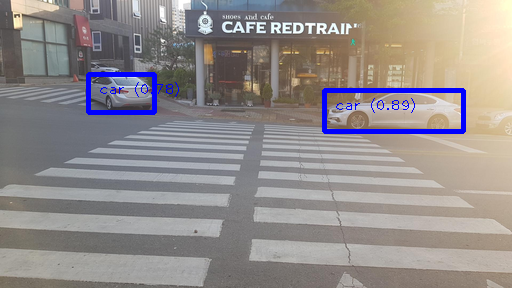

In [ ]:
#@title Run object detection and show the detection results
from PIL import Image
import cv2

INPUT_IMAGE_URL = "/content/drive/MyDrive/test/Bbox_1_new/Bbox_0001/MP_SEL_000004.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.6 #@param {type:"number"}

TEMP_FILE = '/tmp/image.png'

!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
im = Image.open(INPUT_IMAGE_URL)
im.thumbnail((512, 512), Image.ANTIALIAS)
image_np = np.asarray(im)

# Load the TFLite model
options = ObjectDetectorOptions(
      num_threads=8,
      score_threshold=DETECTION_THRESHOLD,
)
detector = ObjectDetector(model_path='/content/drive/MyDrive/test/detect_model.tflite', options=options)

# Run object detection estimation using the model.
detections = detector.detect(image_np)

# Draw keypoints and edges on input image
image_np = visualize(image_np, detections)

# Show the detection result
Image.fromarray(image_np)